Using TensorFlow backend.
/home/pub/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), padding="same", activation="relu")`
/home/pub/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), padding="same", activation="relu")`
/home/pub/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu")`
/home/pub/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu")`
/home/pub/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
/home/pub/anaconda2/lib/python2

(640, 960, 3)
: (640, 960, 1)
((706, 355), (785, 420))


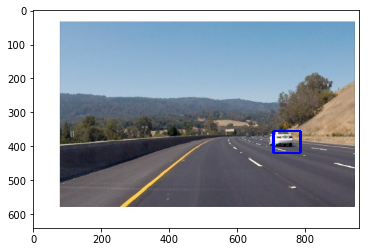

In [1]:
#set github：
#https://github.com/zuoshaobo/self-driving-car/tree/master/vehicle-detection/u-net
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle 

from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
import time
img_rows = 640
img_cols = 960
%matplotlib inline
heatmap_10 = [np.zeros((640,960))]*10
def get_small_unet():
    
    ## Redefining small U-net
    inputs = Input((img_rows, img_cols,3))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    
    return model

def test_new_img(img):
    # Test Unet on new image
    img = cv2.resize(img,(img_cols, img_rows))
    print img.shape
    img = np.reshape(img,(1,img_rows, img_cols,3))
    pred = model.predict(img)
    return pred,img[0]
def smooth_heatmap(heatmap):
    # Smoothing heatmap as average of 10 previous frames
    global heatmap_10
    
    heatmap_10_1 = heatmap_10[1:]
    heatmap_10_1.append(heatmap)
    
    heatmap_10 = heatmap_10_1
    
    heatmap = np.mean(heatmap_10,axis=0)
    
    #heatmap = heatmap_prev*.2 + heatmap*.8
    #heatmap[heatmap>240] = 255
    #heatmap[heatmap<240] = 0
    
    return heatmap 
def get_BB_new_img(img):
    # Get bounding boxes
    pred,img = test_new_img(img)
   # print ':',pred[0].shape
    img  = np.array(img,dtype= np.uint8)
    img_pred = np.array(255*pred[0],dtype=np.uint8)
    print ':',img_pred.shape
    heatmap = img_pred[:,:,0]
    heatmap = smooth_heatmap(heatmap)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img
    
def get_BB_new(img):
    # Take in RGB image
    pred,img = test_new_img(img)
    img  = np.array(img,dtype= np.uint8)
    img_pred = np.array(255*pred[0],dtype=np.uint8)
    heatmap = img_pred[:,:,0]
    heatmap = smooth_heatmap(heatmap)
    #print(np.max(heatmap))
    heatmap[heatmap> 240] = 255
    heatmap[heatmap<=240] = 0    
    labels = label(heatmap)
    
    bbox_all = get_labeled_bboxes(np.copy(img), labels)
    return bbox_all

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)> 40) & (np.max(nonzerox)-np.min(nonzerox)> 40)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image      
            print(bbox)
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)
    # Return the image
    return img
model = get_small_unet()
image = mpimg.imread('download.jpg')
model.load_weights("model_segn_small_0p72.h5")  
result_pipe = get_BB_new_img(image)
plt.imshow(result_pipe)